# TODO

# Import Libraries

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import sklearn
import pickle
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from tqdm import tqdm

# Import Dataset

In [5]:
path = 'Bone Break Classification'
class_list = os.listdir(path)
print(class_list)

['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']


In [6]:
max_width = 0
max_height = 0

for (index, _class) in enumerate(class_list):
    class_path = os.path.join(path, _class)

    train_path = os.path.join(class_path, 'Train')
    for img_path in os.listdir(train_path):
        full_path = os.path.join(train_path, img_path)
        image = cv2.imread(full_path,0)
        height, width = image.shape[:2]
        max_width = max(max_width, width)
        max_height = max(max_height, height)

    test_path = os.path.join(class_path, 'Test')
    for img_path in os.listdir(test_path):
        full_path = os.path.join(test_path, img_path)
        image = cv2.imread(full_path,0)
        height, width = image.shape[:2]
        max_width = max(max_width, width)
        max_height = max(max_height, height)

print(f"Maximum width: {max_width}")
print(f"Maximum height: {max_height}")

max_size = max(max_height, max_width)
print(f"Max size: {max_size}x{max_size}")

Maximum width: 640
Maximum height: 640
Max size: 640x640


In [7]:
def resize_with_padding(image, target_size):
    old_size = image.shape[:2]  
    ratio = float(target_size) / max(old_size)  
    new_size = tuple([int(x * ratio) for x in old_size])  

    resized_image = cv2.resize(image, (new_size[1], new_size[0]))

    delta_w = target_size - new_size[1]
    delta_h = target_size - new_size[0]
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    
    color = [0, 0, 0]  
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    
    return padded_image

In [8]:
train_images, train_classes = [], []
test_images, test_classes = [], []

for (index, _class) in enumerate(class_list):
    class_path = os.path.join(path, _class)

    train_path = os.path.join(class_path, 'Train')
    for img_path in os.listdir(train_path):
        full_path = os.path.join(train_path, img_path)
        image = cv2.imread(full_path,0)
        resized_image = resize_with_padding(image, max_size)
        train_images.append(resized_image)
        train_classes.append(index)

    test_path = os.path.join(class_path, 'Test')
    for img_path in os.listdir(test_path):
        full_path = os.path.join(test_path, img_path)
        image = cv2.imread(full_path,0)
        resized_image = resize_with_padding(image, max_size)
        test_images.append(resized_image)
        test_classes.append(index)    

# Code

## Preprocessing

In [24]:
test_images = np.array(test_images)
train_images = np.array(train_images)
test_classes = np.array(test_classes)
train_classes = np.array(train_classes)

In [25]:
def normalize(image_list):
    return np.array([img.astype(np.float32) / 255.0 for img in image_list])

In [26]:
def preprocess(image_list):
    blurred_image = [cv2.GaussianBlur(img, (5, 5), 0) for img in image_list]
    edges = [cv2.Canny(img, 100, 200) for img in blurred_image]
    return np.array(edges)

In [ ]:
# Kyknya normalize ga perlu deh kalau mau pake traditional method, trus kalo normalize tar lgsg rusak pas lu panggil preprocessnya

normalized_train_images = normalize(train_images)
normalized_test_images = normalize(test_images)
normalized_test_images.shape

(140, 640, 640)

In [29]:
preprocessed_test_images = preprocess(test_images)
preprocessed_train_images = preprocess(train_images)
preprocessed_test_images.shape

(140, 640, 640)

In [ ]:
total_class = len(set(train_classes))
train_classes_categorical = tf.keras.utils.to_categorical(train_classes, total_class)
test_classes_categorical = tf.keras.utils.to_categorical(test_classes, total_class)

In [13]:
X_train = normalized_train_images.reshape(len(normalized_train_images), -1)
X_test = normalized_test_images.reshape(len(normalized_test_images), -1)

In [14]:
y_train = np.argmax(train_classes_categorical, axis=-1)
y_test = np.argmax(test_classes_categorical, axis=-1)

## Model

### CNN

In [15]:
CNN_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(3,3),
        activation='relu',
        input_shape=(max_size, max_size, 1)
    ),
    tf.keras.layers.MaxPool2D(
        pool_size=(2,2)
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='relu'
    ),
    tf.keras.layers.MaxPool2D(
        pool_size=(2,2)
    ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(
        units=128, 
        activation='relu'
    ),
    tf.keras.layers.Dropout(
        rate=0.5
    ),
    tf.keras.layers.Dense(
        units=64, 
        activation='relu'
    ),
    tf.keras.layers.Dropout(
        rate=0.25
    ),
    tf.keras.layers.Dense(
        units=total_class, 
        activation='softmax'
    )
])

In [16]:
# CNN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# CNN_history = CNN_model.fit(train_images, train_classes_categorical, epochs=10, batch_size = 32, validation_split=0.2)

In [17]:
# CNN_model.save('cnn_model.h5')

### ResNet50

In [18]:
resnet50_base = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(max_size, max_size, 1)
)
resnet50_base.trainable = False

resnet50_model = tf.keras.Sequential([
    resnet50_base,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(
        units=128, 
        activation='relu'
    ),
    tf.keras.layers.Dropout(
        rate=0.5
    ),
    tf.keras.layers.Dense(
        units=64, 
        activation='relu'
    ),
    tf.keras.layers.Dropout(
        rate=0.25
    ),
    tf.keras.layers.Dense(
        units=total_class, 
        activation='softmax'
    )
])

ValueError: The input must have 3 channels; Received `input_shape=(640, 640, 1)`

In [ ]:
# resnet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# resnet50_history = CNN_model.fit(train_images, train_classes_categorical, epochs=10, batch_size = 32, validation_split=0.2)

### SVC

In [ ]:
svc_model = SVC(
    kernel='linear',
    probability=True
)
svc_model.fit(X_train, y_train)
svc_prediction = svc_model.predict(X_test)
svc_report = classification_report(y_test, svc_prediction)
svc_accuracy = accuracy_score(y_test, svc_prediction)

In [ ]:
with open('svc_model.pkl', 'wb') as file:
    pickle.dump(svc_model, file)

### RF

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)
rf_model.fit(X_train, y_train)
rf_prediction = svc_model.predict(X_test)
rf_report = classification_report(y_test, rf_prediction)
rf_accuracy = accuracy_score(y_test, rf_prediction)

## Visualization

# Code 2

In [18]:
X_train, y_train = [], []
X_test, y_test = [], []

for (index, _class) in enumerate(class_list):
    class_path = os.path.join(path, _class)

    train_path = os.path.join(class_path, 'Train')
    for img_path in os.listdir(train_path):
        full_path = os.path.join(train_path, img_path)
        image = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (32,32))
        X_train.append(image)
        y_train.append(index)

    test_path = os.path.join(class_path, 'Test')
    for img_path in os.listdir(test_path):
        full_path = os.path.join(test_path, img_path)
        image = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (32,32))
        X_test.append(image)
        y_test.append(index)

# X_train = np.array(X_train)
# X_test = np.array(X_test)
# y_train = np.array(y_train)
# y_test = np.array(y_test)
# X_train = X_train.astype('float32') / 255
# X_test = X_test.astype('float32') / 255

In [129]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test,
                                            	test_size=0.3,
                                            	random_state=42)

In [130]:
num_classes = len(class_list)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)

In [131]:
img_rows,img_cols = 512, 512
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        filters=6, 
        kernel_size=(3,3), 
        activation='relu',
        input_shape=(img_rows,img_cols,1) 
    ),
    tf.keras.layers.MaxPooling2D(
        pool_size=(2,2),
        strides=2
    ),
    tf.keras.layers.Conv2D(
        filters=6,
        kernel_size=(3,3),
        activation='relu'
    ),
    tf.keras.layers.MaxPooling2D(
        pool_size=(2,2),
        strides=2
    ),
    # tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(
    #     units=120, 
    #     activation="relu"
    # ),
    tf.keras.layers.Dense(
        units=60, 
        activation="relu"
    ),
    tf.keras.layers.Dense(
        units=10, 
        activation="softmax"
    )
])

In [132]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), callbacks=tf.keras.callbacks.EarlyStopping("val_loss", patience = 10))

Epoch 1/10
16/16 [==============================] - 23s 1s/step - loss: 3.9208 - accuracy: 0.1143 - val_loss: 2.2740 - val_accuracy: 0.2143
Epoch 2/10
16/16 [==============================] - 21s 1s/step - loss: 2.2850 - accuracy: 0.1264 - val_loss: 2.3150 - val_accuracy: 0.1429
Epoch 3/10
16/16 [==============================] - 22s 1s/step - loss: 2.2818 - accuracy: 0.1153 - val_loss: 2.2948 - val_accuracy: 0.1429
Epoch 4/10
16/16 [==============================] - 22s 1s/step - loss: 2.2462 - accuracy: 0.1274 - val_loss: 2.3107 - val_accuracy: 0.1667
Epoch 5/10
16/16 [==============================] - 23s 1s/step - loss: 2.2676 - accuracy: 0.1537 - val_loss: 2.3056 - val_accuracy: 0.1190
Epoch 6/10
16/16 [==============================] - 22s 1s/step - loss: 2.2444 - accuracy: 0.1557 - val_loss: 2.3172 - val_accuracy: 0.1190
Epoch 7/10
16/16 [==============================] - 22s 1s/step - loss: 2.2119 - accuracy: 0.1689 - val_loss: 2.3434 - val_accuracy: 0.1667
Epoch 8/10
16/16 [==

In [111]:
pred = model.predict(X_test)
pred_class = np.argmax(pred, axis=1)
actual_class = np.argmax(y_test, axis=1)

4/4 [==============================] - 0s 8ms/step


In [112]:
for i in range(20):
    actual_label = class_list[actual_class[i]]
    pred_label = class_list[pred_class[i]]
    print(f"actual = {actual_label}, pred = {pred_label}")

actual = Fracture Dislocation, pred = Fracture Dislocation
actual = Comminuted fracture, pred = Comminuted fracture
actual = Longitudinal fracture, pred = Greenstick fracture
actual = Pathological fracture, pred = Greenstick fracture
actual = Pathological fracture, pred = Longitudinal fracture
actual = Hairline Fracture, pred = Comminuted fracture
actual = Fracture Dislocation, pred = Fracture Dislocation
actual = Comminuted fracture, pred = Greenstick fracture
actual = Longitudinal fracture, pred = Longitudinal fracture
actual = Fracture Dislocation, pred = Pathological fracture
actual = Comminuted fracture, pred = Hairline Fracture
actual = Oblique fracture, pred = Avulsion fracture
actual = Impacted fracture, pred = Avulsion fracture
actual = Oblique fracture, pred = Greenstick fracture
actual = Greenstick fracture, pred = Greenstick fracture
actual = Fracture Dislocation, pred = Hairline Fracture
actual = Longitudinal fracture, pred = Avulsion fracture
actual = Impacted fracture, p

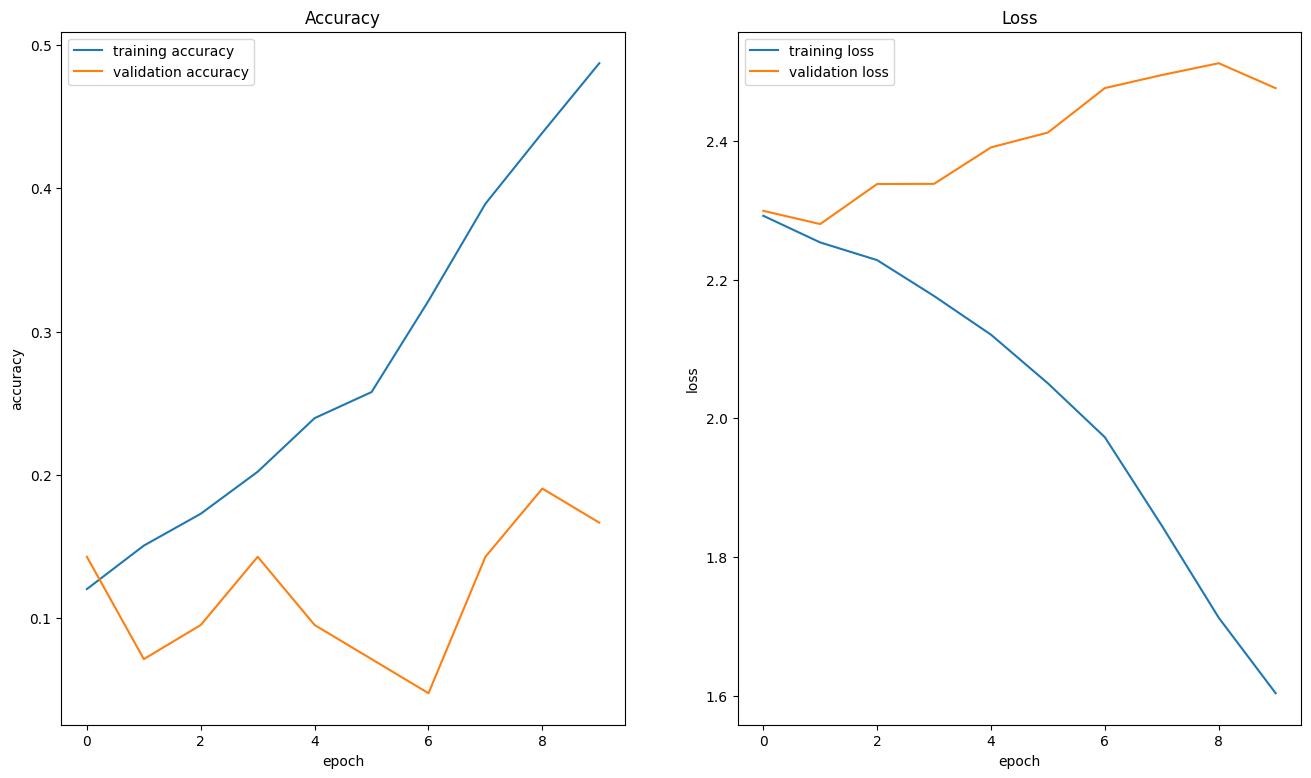

In [116]:
plt.figure(figsize=(16,9))
plt.subplot(1,2,1)
plt.title("Accuracy")
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")

plt.subplot(1,2,2)
plt.title("Loss")
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.show()

In [148]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load pretrained VGG16 model without the top layer
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Extract features
X_train_cnn = vgg.predict(preprocess_input(X_train))
X_test_cnn = vgg.predict(preprocess_input(X_test))

# Flatten the features
X_train_cnn_flat = X_train_cnn.reshape(X_train_cnn.shape[0], -1)
X_test_cnn_flat = X_test_cnn.reshape(X_test_cnn.shape[0], -1)

# Train a classifier
svc_model = SVC(kernel='linear', C=1.0)
svc_model.fit(X_train_cnn_flat, y_train)

# Evaluate
svc_predictions = svc_model.predict(X_test_cnn_flat)
print("Classification Report:")
print(classification_report(y_test, svc_predictions))


ValueError: in user code:

    File "c:\Users\ASUS\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\ASUS\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ASUS\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\ASUS\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 2079, in predict_step
        return self(x, training=False)
    File "c:\Users\ASUS\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\ASUS\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\input_spec.py", line 251, in assert_input_compatibility
        f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer 'vgg16' (type Functional).
    
    Input 0 of layer "block1_conv1" is incompatible with the layer: expected min_ndim=4, found ndim=3. Full shape received: (None, 32, 32)
    
    Call arguments received by layer 'vgg16' (type Functional):
      • inputs=tf.Tensor(shape=(None, 32, 32), dtype=float32)
      • training=False
      • mask=None


# Code 3

In [42]:
X_train, y_train = [], []
X_test, y_test = [], []

for (index, _class) in enumerate(class_list):
    class_path = os.path.join(path, _class)

    train_path = os.path.join(class_path, 'Train')
    for img_path in os.listdir(train_path):
        full_path = os.path.join(train_path, img_path)
        image = cv2.imread(full_path)
        image = cv2.resize(image, (128,128))
        X_train.append(image)
        y_train.append(index)

    test_path = os.path.join(class_path, 'Test')
    for img_path in os.listdir(test_path):
        full_path = os.path.join(test_path, img_path)
        image = cv2.imread(full_path)
        image = cv2.resize(image, (128,128))
        X_test.append(image)
        y_test.append(index)

# X_train = np.array(X_train)
# X_test = np.array(X_test)
# y_train = np.array(y_train)
# y_test = np.array(y_test)
# X_train = X_train.astype('float32') / 255
# X_test = X_test.astype('float32') / 255

In [50]:
def extract_sift_features(images):
    sift = cv2.SIFT_create()
    descriptors_list = []
    
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        if descriptors is not None:
            descriptors_list.append(descriptors)
    return descriptors_list

In [54]:
def create_bovw(descriptors, n_clusters=50):
    descriptors = np.vstack(descriptors)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(descriptors)
    visual_words = kmeans.cluster_centers_
    
    bovw_features = []
    for descriptor in descriptors:
        histogram = np.zeros(n_clusters)
        for desc in descriptor:
            cluster_idx = kmeans.predict(desc.reshape(1, -1))[0]
            histogram[cluster_idx] += 1
        bovw_features.append(histogram)
    return np.array(bovw_features), kmeans


In [56]:
def create_bovw(descriptors_list, num_clusters=100):
    # Combine all descriptors into a single array
    all_descriptors = np.vstack(descriptors_list)

    # KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(all_descriptors)

    # Map descriptors to clusters
    bovw_features = []
    for descriptor in descriptors_list:
        histogram = np.zeros(num_clusters)
        for desc in descriptor:
            if len(desc) == kmeans.n_features_in_:  # Ensure desc matches KMeans feature size
                cluster_idx = kmeans.predict(desc.reshape(1, -1))[0]
                histogram[cluster_idx] += 1
        bovw_features.append(histogram)
    
    return np.array(bovw_features), kmeans


In [58]:
X_train_descriptors = extract_sift_features(X_train)
X_test_descriptors = extract_sift_features(X_test)

X_train_bovw_features, X_train_kmeans = create_bovw(X_train_descriptors)
X_test_bovw_features, X_test_kmeans = create_bovw(X_test_descriptors)

In [59]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_bovw_features, y_train)
rf_predictions = rf_model.predict(X_test_bovw_features)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))


Random Forest Accuracy: 0.12142857142857143
              precision    recall  f1-score   support

           0       0.06      0.07      0.07        14
           1       0.18      0.50      0.26        14
           2       0.23      0.26      0.24        19
           3       0.09      0.12      0.10        16
           4       0.14      0.20      0.17        10
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00        12
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00        18
           9       0.00      0.00      0.00        12

    accuracy                           0.12       140
   macro avg       0.07      0.12      0.08       140
weighted avg       0.08      0.12      0.09       140



c:\Users\ASUS\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [60]:
svc_model = SVC(kernel='linear', C=1, random_state=42)
svc_model.fit(X_train_bovw_features, y_train)
svc_predictions = svc_model.predict(X_test_bovw_features)

print("SVC Accuracy:", accuracy_score(y_test, svc_predictions))
print(classification_report(y_test, svc_predictions))


SVC Accuracy: 0.09285714285714286
              precision    recall  f1-score   support

           0       0.12      0.14      0.13        14
           1       0.08      0.07      0.08        14
           2       0.13      0.16      0.14        19
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00         9
           6       0.33      0.25      0.29        12
           7       0.00      0.00      0.00        16
           8       0.27      0.17      0.21        18
           9       0.17      0.08      0.11        12

    accuracy                           0.09       140
   macro avg       0.11      0.09      0.10       140
weighted avg       0.12      0.09      0.10       140

